In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## 残差块
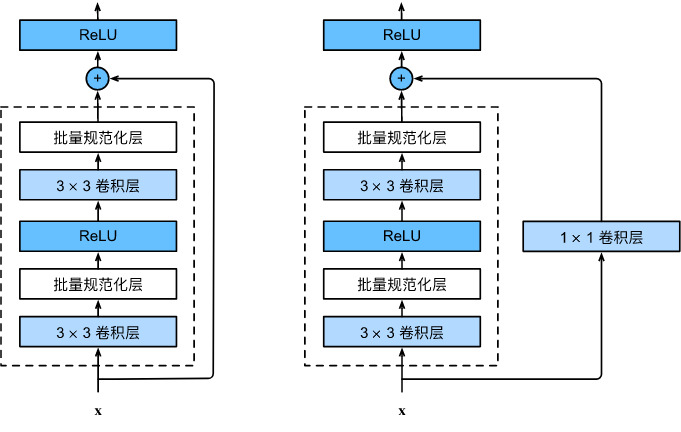
- ResNet沿用了VGG完整的3x3卷积层设计，残差块里首先有2个有相同输出通道数的3x3卷积层，每个卷积层后接一个批量规范化层和ReLU激活函数。
    - 3x3卷积层的说明：https://www.cnblogs.com/kphang/p/17016448.html
- 通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。
- 这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加，这一步可能涉及到通道数的改变，就需要引入一个额外的1x1卷积层调整通道数后再做相加运算。
- 在模型训练过程中，批量规范化利用小批量的均值和标准差，不断调整神经网络的中间输出，使整个神经网络各层的中间输出值更加稳定。

In [5]:
# 残差块
class Residual(nn.Module):
    # 初始化残差块中需要的层；
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    # 使用初始化残差块中的层，完成前向传递；
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

小测试：

In [6]:
# 输入输出通道数一致的情况；
blk = Residual(3, 3)
X = torch.rand(4,3,6,6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [8]:
# 输入输出通道数不一致，增加输出通道数的同时，减半输出高和宽；
blk = Residual(3,6,use_1x1conv=True, strides=2)
blk(X).shape

# 常用，高宽减半通道数加倍；

torch.Size([4, 6, 3, 3])

## ResNet模型

ResNet的前两层跟之前介绍的GoogLeNet中的一样： 在输出通道数为64、步幅为2的$7 \times 7$卷积层后，接步幅为2的$3 \times 3$的最大汇聚层。 不同之处在于ResNet每个卷积层后增加了批量规范化层。

In [9]:
b1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2,padding=1))

GoogLeNet在后面接了4个由Inception块组成的模块。 ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。 第一个模块的通道数同输入通道数一致。 

由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

下面我们来实现这个模块。注意，我们对第一个模块做了特别处理。

In [10]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [11]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [12]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

## 训练模型

KeyboardInterrupt: 

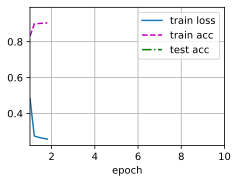

In [13]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())